# Behavioral Patterns

The behavioral patterns are guidelines suggested to create classes that allows to communicate objects to each other. The goal of the behavioral patterns is to make those interactions easier and more understandable.

The five creational patterns available are:
1. Chain of Responsability
2. Command
3. Iterator
4. Mediator
5. Memento
6. Observer
7. State
8. Strategy
9. Template method
10. Visitor

Again, we are going to be convering eaach of the possible patterns and making some examples in the context of machine learning engineering.

# Visitor

**What is a visitor?**

This is design pattern that defines the skeleton of an algorithm and allows that all child classes modify the inner functionalities, but keeping the same logic.

**When should we use it?**

This design pattern is suggested when a different pieces of code behave similarly and there are just small differences in the code.

**Analogy:**

You're an insurance guy. You need to sell as many insurances as possible. You manage different clients from different segments. Instead of offering the same package for all clients, you will provide different insurances with suitable features for each client.

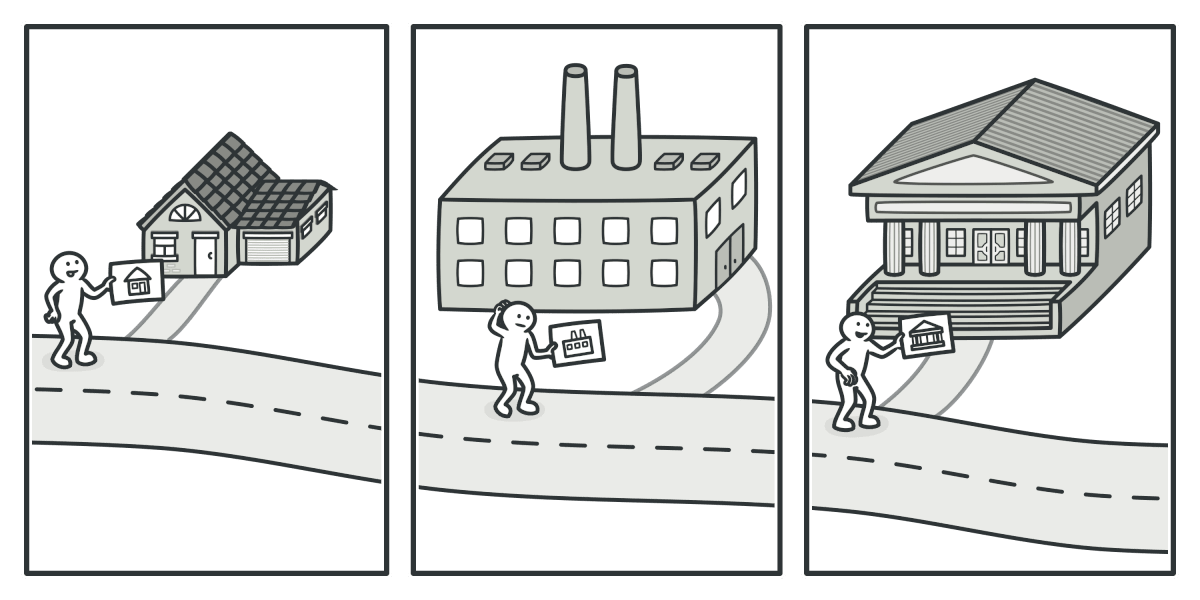

**Reference:** https://refactoring.guru/design-patterns/visitor

**Scenario**

You're a machine learning engineer executing a forecasting project. You need to test different forecasting models quickly, so you've decided to create a unified wrapper for ARIMA, Theta, and Holt-Winters. You already have created a common framework that can handle time-series properly. However, this only can handle a unique time-series by itself. Wee need a way to be able to make forecast over several time-series from a single model instance.

Let's create a random time-series for the modeling

In [102]:
from utilsforecast.data import generate_series
from utilsforecast.plotting import plot_series

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel

from abc import ABC

import pandas as pd

In [103]:
data = generate_series(n_series=10, freq="M", with_trend=True, seed=99)

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/utilsforecast/data.py:108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


Load the classes from the previous notebook

In [104]:
class ForecastingModel(ABC):
    def __init__(self, *model_args, **model_kwargs):
        self.model_instance = None
        self.fitted_model = None
        self.model_args = model_args
        self.model_kwargs = model_kwargs

    def fit(self, df: pd.DataFrame, date_col: str, target_col: str) -> None:
        df = df.copy()
        df = df.sort_values(by=date_col)
        df = df.set_index(date_col)
        y = df[target_col]
        self.fitted_model = self.model_instance(
            y, *self.model_args, **self.model_kwargs
        ).fit()

    def predict(self, steps):
        return self.fitted_model.forecast(steps=steps).reset_index()

In [105]:
class NewARIMAForecaster(ForecastingModel):
    def __init__(self, order=(1, 1, 1), *args, **kwargs):
        self.model_kwargs = {"order": order}
        if kwargs:
            self.model_kwargs.update(kwargs)
        self.model_args = args
        super().__init__(*self.model_args, **self.model_kwargs)
        self.model_instance = ARIMA

    def predict(self, steps):
        result = super().predict(steps)
        result = result.rename(
            columns={"index": "ds", "predicted_mean": "ARIMAPredictions"}
        )
        return result

In [106]:
class NewHoltWintersForecaster(ForecastingModel):
    def __init__(self, *args, **kwargs):
        self.model_args = args
        self.model_kwargs = kwargs
        super().__init__(*self.model_args, **self.model_kwargs)
        self.model_instance = ExponentialSmoothing

    def predict(self, steps):
        result = super().predict(steps=steps)
        result = result.rename(columns={"index": "ds", 0: "HoltWintersPredictions"})
        return result

In [107]:
class NewThetaForecaster(ForecastingModel):
    def __init__(self, *args, **kwargs):
        self.model_args = args
        self.model_kwargs = kwargs
        super().__init__(*self.model_args, **self.model_kwargs)
        self.model_instance = ThetaModel
        self.max_date_fitted = None
        self.infer_freq = None

    def fit(self, df, date_col, target_col):
        self.max_date_fitted = df[date_col].max()
        self.infer_freq = pd.infer_freq(df[date_col])
        return super().fit(df, date_col, target_col)

    def predict(self, steps):
        result = super().predict(steps=steps)
        result = result.rename(columns={"index": "ds", "forecast": "ThetaPredictions"})
        prediction_range = pd.date_range(
            start=self.max_date_fitted,
            periods=steps + 1,
            freq=self.infer_freq,
            inclusive="neither",
        )
        result["ds"] = prediction_range
        return result

## Antipattern

The most easiest antipattern is to create a for loop for each possible unique time-series in the dataset.

In [108]:
arima_results = []
theta_results = []
holt_winters_results = []

for item in data["unique_id"].unique():
    df_instance = data[data["unique_id"] == item]
    arima_model = NewARIMAForecaster()
    arima_model.fit(df_instance, date_col="ds", target_col="y")
    arima_forecast = arima_model.predict(steps=12)
    arima_forecast["unique_id"] = item
    arima_results.append(arima_forecast)

    theta_model = NewThetaForecaster()
    theta_model.fit(df_instance, date_col="ds", target_col="y")
    theta_forecast = theta_model.predict(steps=12)
    theta_forecast["unique_id"] = item
    theta_results.append(theta_forecast)

    holt_winters_model = NewHoltWintersForecaster()
    holt_winters_model.fit(df_instance, date_col="ds", target_col="y")
    holt_winters_forecast = holt_winters_model.predict(steps=12)
    holt_winters_forecast["unique_id"] = item
    holt_winters_results.append(holt_winters_forecast)


arima_results = pd.concat(arima_results)
theta_results = pd.concat(theta_results)
holt_winters_results = pd.concat(holt_winters_results)

forecast = pd.merge(
    arima_results,
    theta_results,
    on=["ds", "unique_id"],
    how="inner",
)

forecast = pd.merge(
    forecast,
    holt_winters_results,
    on=["ds", "unique_id"],
    how="inner",
)

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:

In [109]:
forecast

,ds,ARIMAPredictions,unique_id,ThetaPredictions,HoltWintersPredictions
0,2014-12-31,164.192311,0,167.356867,164.192130
1,2015-01-31,164.192334,0,136.966612,164.192130
2,2015-02-28,164.192334,0,140.306210,164.192130
3,2015-03-31,164.192334,0,143.806530,164.192130
4,2015-04-30,164.192334,0,146.960747,164.192130
...,...,...,...,...,...
115,2041-02-28,427.568245,9,417.535232,427.879643
116,2041-03-31,427.566026,9,421.681562,427.879643
117,2041-04-30,427.564708,9,425.867834,427.879643
118,2041-05-31,427.563925,9,429.762319,427.879643


**What are the problems with the previous code?**

We don't have an object that can actually performs this action. This code is hard to duplicate and maintain. We need somehow to define an standard way to make the inference. In addition, if we increase the models trained our code starts to repeat over and over, so we fall into DRY again.

**How to solve this antipattern?**

1. Create a `visitor` class that manages the model training for several items in the times-series.
2. Add a `visition function` into the base class that manages how the `visitor` class will work out.

## Pattern

Let's modify the original base forecasting class

In [110]:
class NewForecastingModel(ABC):
    def __init__(self, *model_args, **model_kwargs):
        self.model_instance = None
        self.fitted_model = None
        self.model_args = model_args
        self.model_kwargs = model_kwargs

    def fit(self, df: pd.DataFrame, date_col: str, target_col: str) -> None:
        df = df.copy()
        df = df.sort_values(by=date_col)
        df = df.set_index(date_col)
        y = df[target_col]
        self.fitted_model = self.model_instance(
            y, *self.model_args, **self.model_kwargs
        ).fit()

    def predict(self, steps):
        return self.fitted_model.forecast(steps=steps).reset_index()

    def accept_visitor(
        self,
        visitor,
        df: pd.DataFrame,
        date_col: str,
        target_col: str,
        items_col: str,
        steps: int,
    ):
        return visitor.forecast_several_items(
            model=self,
            df=df,
            date_col=date_col,
            target_col=target_col,
            items_col=items_col,
            steps=steps,
        )

Define the visitor

In [111]:
class ForecastVisitor:
    def forecast_several_items(
        self,
        model,
        df: pd.DataFrame,
        date_col: str,
        target_col: str,
        items_col: str,
        steps: int,
    ) -> pd.DataFrame:
        forecast_results = []
        for item in df[items_col].unique():
            df_instance = df[df[items_col] == item]
            model.fitted_model = None
            model.fit(df_instance, date_col=date_col, target_col=target_col)
            forecast = model.predict(steps=steps)
            forecast["unique_id"] = item
            forecast_results.append(forecast)
        return pd.concat(forecast_results)

Modify the previous models to inherit from the new base class

In [112]:
class NewARIMAForecaster(NewForecastingModel):
    def __init__(self, order=(1, 1, 1), *args, **kwargs):
        self.model_kwargs = {"order": order}
        if kwargs:
            self.model_kwargs.update(kwargs)
        self.model_args = args
        super().__init__(*self.model_args, **self.model_kwargs)
        self.model_instance = ARIMA

    def predict(self, steps):
        result = super().predict(steps)
        result = result.rename(
            columns={"index": "ds", "predicted_mean": "ARIMAPredictions"}
        )
        return result

In [113]:
class NewHoltWintersForecaster(NewForecastingModel):
    def __init__(self, *args, **kwargs):
        self.model_args = args
        self.model_kwargs = kwargs
        super().__init__(*self.model_args, **self.model_kwargs)
        self.model_instance = ExponentialSmoothing

    def predict(self, steps):
        result = super().predict(steps=steps)
        result = result.rename(columns={"index": "ds", 0: "HoltWintersPredictions"})
        return result

In [114]:
class NewThetaForecaster(NewForecastingModel):
    def __init__(self, *args, **kwargs):
        self.model_args = args
        self.model_kwargs = kwargs
        super().__init__(*self.model_args, **self.model_kwargs)
        self.model_instance = ThetaModel
        self.max_date_fitted = None
        self.infer_freq = None

    def fit(self, df, date_col, target_col):
        self.max_date_fitted = df[date_col].max()
        self.infer_freq = pd.infer_freq(df[date_col])
        return super().fit(df, date_col, target_col)

    def predict(self, steps):
        result = super().predict(steps=steps)
        result = result.rename(columns={"index": "ds", "forecast": "ThetaPredictions"})
        prediction_range = pd.date_range(
            start=self.max_date_fitted,
            periods=steps + 1,
            freq=self.infer_freq,
            inclusive="neither",
        )
        result["ds"] = prediction_range
        return result

Let's try a the new models

In [115]:
theta_model = NewThetaForecaster()
arima_model = NewARIMAForecaster()
holt_winters_model = NewHoltWintersForecaster()

In [116]:
visitor = ForecastVisitor()

Add the visitor into the theta model to give this additional capability

In [117]:
forecast_theta = theta_model.accept_visitor(
    visitor, df=data, date_col="ds", target_col="y", items_col="unique_id", steps=12
)
forecast_arima = arima_model.accept_visitor(
    visitor, df=data, date_col="ds", target_col="y", items_col="unique_id", steps=12
)
forecast_holt_winters = holt_winters_model.accept_visitor(
    visitor, df=data, date_col="ds", target_col="y", items_col="unique_id", steps=12
)

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/forecasting/theta.py:44: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  return DeterministicTerm._extend_index(index, steps)
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/forecasting/theta.py:44: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  return DeterministicTerm._extend_index(index, steps)
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/statsmodels/tsa/forecasting/theta.py:44: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative t

Concat all the results

In [118]:
forecast = pd.merge(
    forecast_theta,
    forecast_arima,
    on=["ds", "unique_id"],
    how="inner",
)
forecast = pd.merge(
    forecast,
    forecast_holt_winters,
    on=["ds", "unique_id"],
    how="inner",
)

Let's see the results

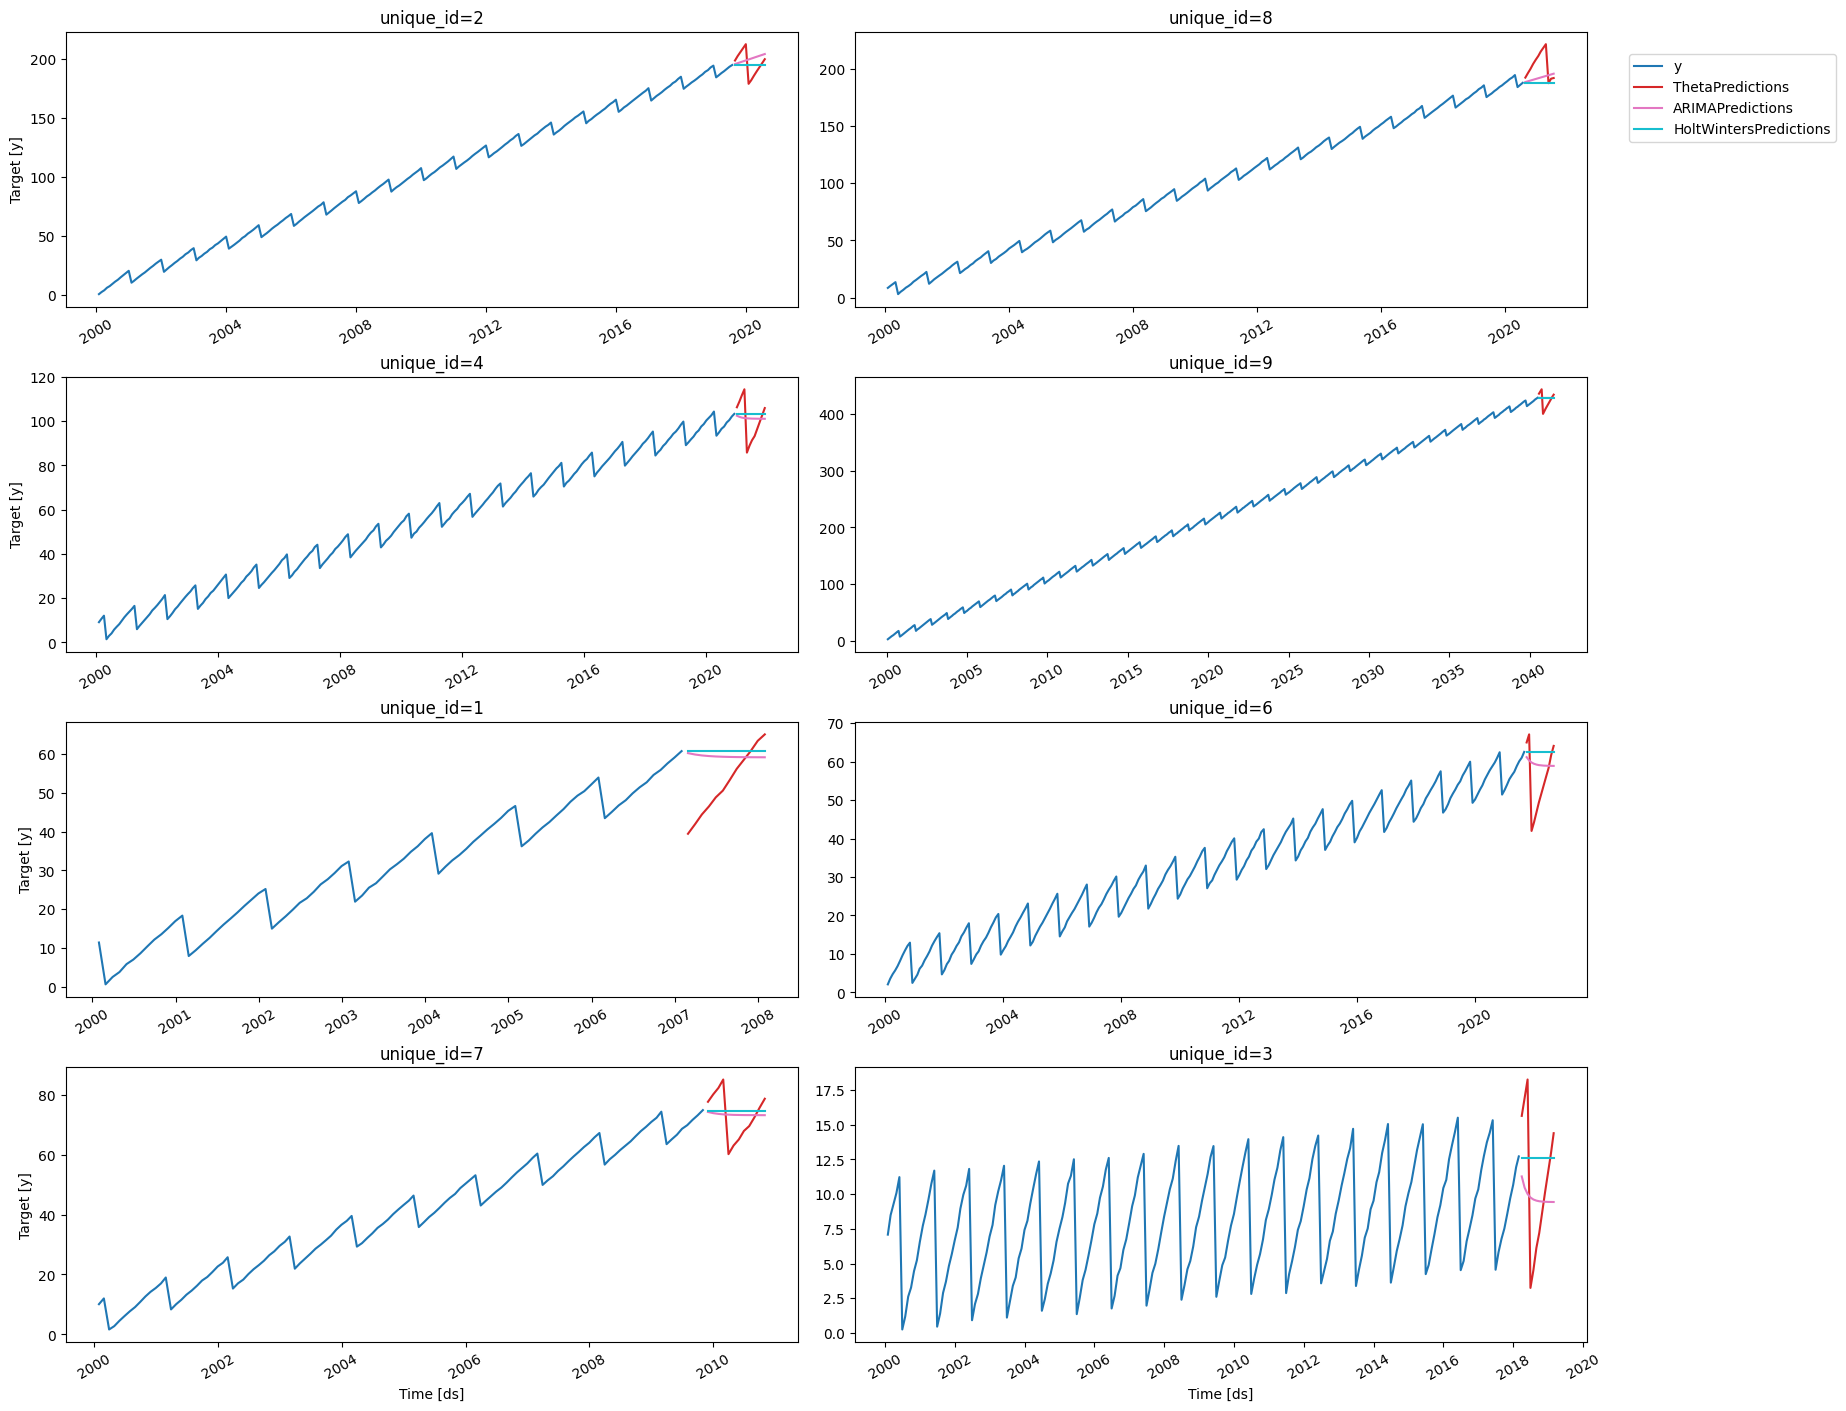

In [119]:
plot_series(data, forecast)

As you can see the visitor allowed to incorporate the forecasting over multiple time-series at the same time without modifying the inner functionality of the code.